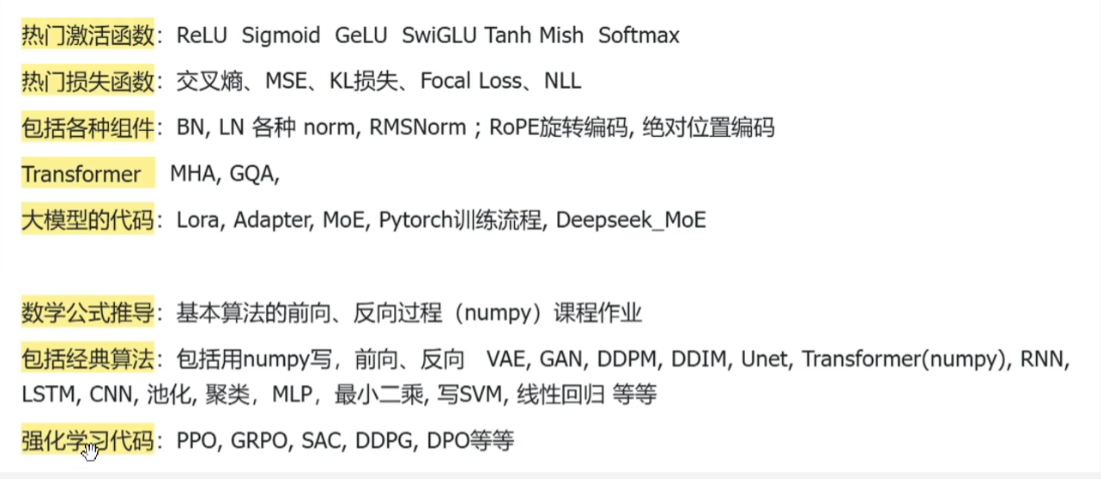

## 激活函数

In [1]:
import numpy as np
def relu(x):
    return np.maximum(0, x)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def swish(x, beta = 1.0):
    return x * sigmoid(beta * x)
def swiglu(x, w1, w2, bq, b2, beta = 1.0):
    hidden1 = np.dot(x, w1) + b1
    hidden2 = np.dot(x, w2) + b2
    return swish(hidden1) * hidden2
def softmax(x):
    x_max = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    

In [2]:
x1 = np.array([2.0, 1.0, 0.1])
print("输入向量:", x1)
print("Softmax 输出:", softmax(x1))

输入向量: [2.  1.  0.1]
Softmax 输出: [0.65900114 0.24243297 0.09856589]


## 损失函数

In [7]:
# --- 1. 定义函数 ---
def cross_entropy(y_pred, y_true):
    y_pred_soft = softmax(y_pred)
    loss = -np.sum(y_true * np.log(y_pred_soft)) / y_pred.shape[0]
    return loss

def NLLloss(y_pred, y_true):
    return -np.sum(y_true * np.log(y_pred))

def kl(y_pred, y_true):
    return np.sum(y_true * np.log(y_true / y_pred))
    
# --- 2. 准备数据 ---
y_pred_logits = np.array([[5.0, 1.0, 0.1, 0.2], [0.1, 3.0, 0.5, 0.2], [1.0, 1.2, 1.1, 1.5]])
y_true_onehot = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
y_pred_probs = softmax(y_pred_logits)
y_pred_log_probs = np.log(y_pred_probs)
y_true_distribution_smooth = np.array([[0.9, 0.05, 0.03, 0.02], [0.02, 0.03, 0.9, 0.05], [0.05, 0.1, 0.15, 0.7]])

# --- 3. 执行测试并打印结果 ---
print(f"交叉熵损失: {cross_entropy(y_pred_logits, y_true_onehot):.4f}")
print(f"负对数似然损失: {NLLloss(y_pred_log_probs, y_true_onehot):.4f}")
print(f"KL 散度 (vs one-hot): {kl(y_pred_probs, y_true_onehot):.4f}")
print(f"KL 散度 (vs 平滑分布): {kl(y_pred_probs, y_true_distribution_smooth):.4f}")
print(f"KL 散度 (完美预测): {kl(y_true_distribution_smooth, y_true_distribution_smooth):.4f}")

交叉熵损失: 1.2728
负对数似然损失: nan
KL 散度 (vs one-hot): nan
KL 散度 (vs 平滑分布): 2.5541
KL 散度 (完美预测): 0.0000


E:\Anaconda3\envs\Gtorch\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
E:\Anaconda3\envs\Gtorch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
E:\Anaconda3\envs\Gtorch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


In [8]:
import torch
import lpips

loss_fn = lpips.LPIPS(net = 'vgg')

img0 = torch.randn(1, 3, 64, 64)
img1 = torch.randn(1, 3, 64, 64)

d = loss_fn(img0, img1)
print(f"LPIPS Distance: {d.item():.4f}")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: E:\Anaconda3\envs\Gtorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
LPIPS Distance: 0.2992


## 大模型各种组件

## Norm

In [7]:
import torch.nn as nn
# Batch之间做归一化，图片任务
class BatchNorm(nn.Module):
    def __init__(self, num_feature, eps = 1e-5, rho = 0.1):
        super(BacthNorm, self).__init__()
        self.gamma = nn.Paramter(torch.ones(num_feature))
        self.beta = nn.Paramter(torch.zeros(num_feature))
        self.eps = eps
        self.rho = rho
        
        # 有些参数不参与更新
        self.register_buffer("running_mean", torch.zeros(num_feature))
        self.register_buffer("running_var", torch.ones(num_feature))
        
        
    def forward(self, x):
        # [batch, seq_len, num_feature]
        # 均值和方差
        if self.training:
            # 注意到batchnorm中是对dim=0,1即batch和seqlen维度
            mean = x.mean(dim=(0, 1), keepdim=True)
            var = x.var(dim=(0, 1), keepdim=True)
            
            self.running_mean = (1 - self.rho) * self.running_mean + self.rho * mean
            self.running_var = (1 - self.rho) * self.running_var + self.rho * var
            
        else:
            mean = self.running_mean.view(1, 1, -1)
            var = self.running_var.view(1, 1, -1)
        # 分母加上eps，防止除0中断
        x_ = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_ + self.beta

# 特征之间做归一化，建模语言，在一条句子中做norm，适合nlp任务
class LayerNorm(nn.Module):
    def __init__(self, num_feature, eps = 1e-5):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Paramter(torch.ones(num_feature))
        self.beta = nn.Paramter(torch.zeros(num_feature))
        self.eps = eps
        
        # 有些参数不参与更新
        self.register_buffer("running_mean", torch.zeros(num_feature))
        self.register_buffer("running_var", torch.ones(num_feature))
        
        
    def forward(self, x):
        # [batch, seq_len, num_feature]
        # 均值和方差
        if self.training:
            # dim=-1即numfeature（视觉中特征通道数C）
            mean = x.mean(dim = -1 , keepdim=True)
            var = x.var(dim = - 1, keepdim=True)
            
            self.running_mean = (1 - self.rho) * self.running_mean + self.rho * mean
            self.running_var = (1 - self.rho) * self.running_var + self.rho * var
            
        else:
            mean = self.running_mean.view(1, 1, -1)
            var = self.running_var.view(1, 1, -1)
        # 分母加上eps，防止除0中断
        x_ = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_ + self.beta
    
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps = 1e-5):
        super(RMSNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.eps = eps
    
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, dim = -1, keepdim = True))
        x_ = x / (rms + eps)
        return self.gamma * x_

## 位置编码position encoding

In [2]:
import torch.nn as nn
# 绝对位置编码：在句子长度过长时，后期频率变化快，稳定性不强
class PositionAb(nn.Module):
    def __init__(self, d_model, maxlen, base = 10000):
        super(PositionAb, self).__init__()
        self.encoding = torch.zeros(maxlen, d_model)
        pos = torch.arange(0, maxlen).float().unsqueeze()
        _2i = torch.arange(0, d_model, 2)
        self.encoding[:, 0::2] = torch.sin(pos / (base ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (base ** (_2i / d_model)))       
        
    def forward(self, x):
        x_len = x.shape[0]
        return self.encoding[:x_len, :]

In [3]:
# 旋转位置编码，常用于多头注意力机制中
class PositionRo(nn.Module):
    def __init__(self, head_dim, maxlen, base = 10000):
        self.head_dim = head_dim
        self.maxlen = maxlen
        self.base = base
        
        # 用数列知识，i:12345,2(i - 1):0246810
        inv_freq = base ** -(torch.arange(0, heam_dim, 2) / head_dim)
        t = torch.arange(self.maxlen)
        freqs = torch.einsum("i, j -> ij", t, inv_freq)
        emb = torch.cat((freqs, freqs), dim = -1)
        
        self.register_buffer("cos", emb.cos()[None, None, :, :])  # batch, head_num, seq_len, head_dim
        self.register_buffer("sin", emb.sin()[None, None, :, :])   
        
    def apply_rotary(self, x):
        x_len = x.shape[2]
        cos = self.cos[:, :, :xlen, :]
        sin = self.sin[:, :, :xlen, :]
        
        x1, x2 = x[..., :self.head_dim // 2], x[..., self.head_dim //2:]
        x_ = torch.cat([-x2, x11], dim = -1)
        
        return x * cos + x_ * sim
    
    def forward(self, q, k):
        return self.apply_rotary(q), self.apply_rotary(k)

## Group-Query-Attention
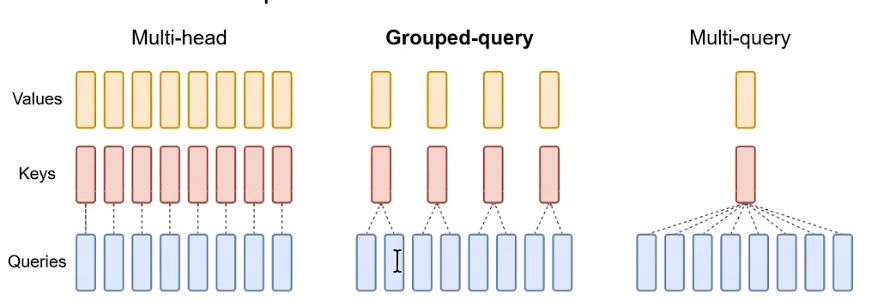

## 大模型微调：Lora，RLHF，Prompt，Adapter

### LoRA：Low Rank，在低秩的向量空间中进行微调，用小权重对大模型微调
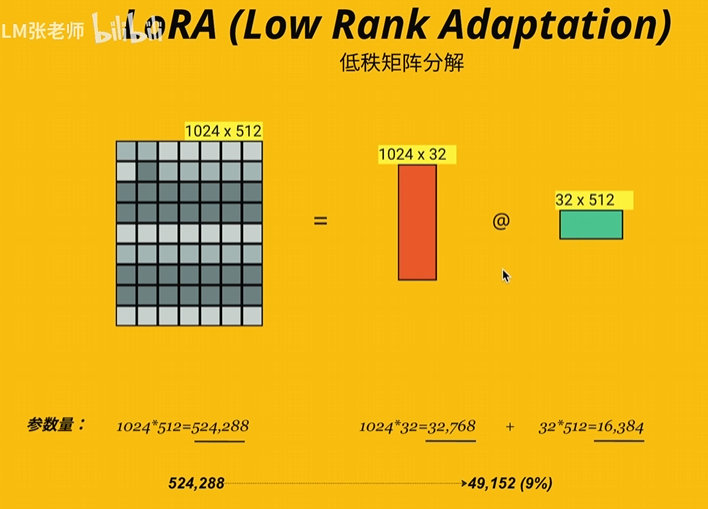
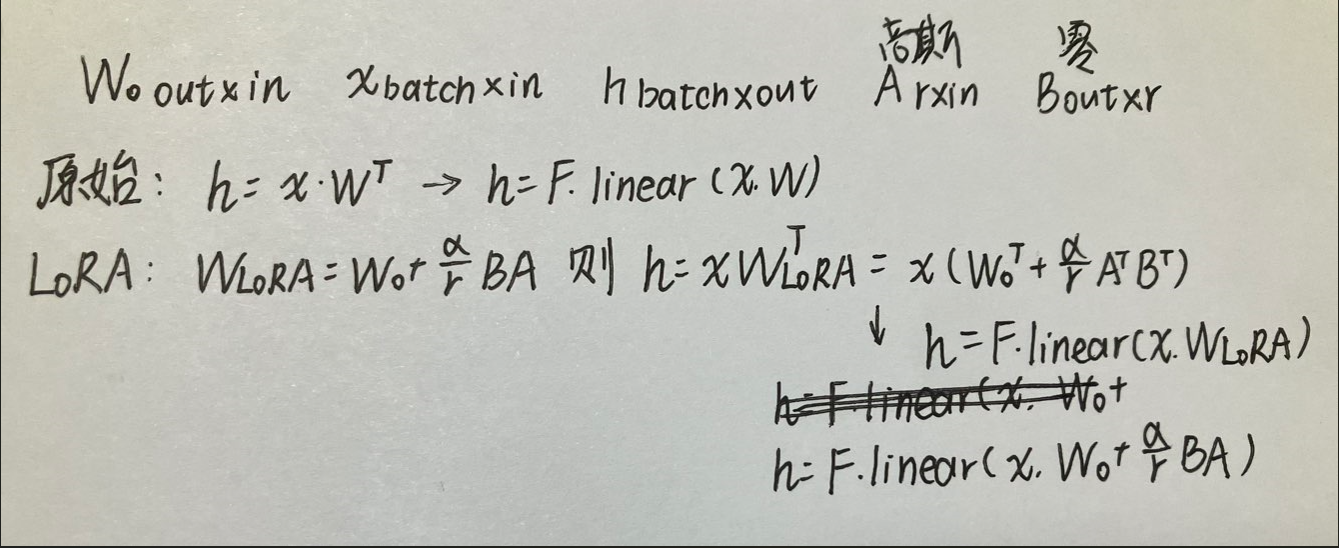

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LoRALinear(nn.Module):
    # in_features:x的维度，out_features:h的维度，merge:是否合并，rank:低秩向量的维度，lora_alpha:低秩向量的系数，dropout:dropout的系数
    def __init__(self, in_features, out_features, merge, rank = 16, lora_alpha = 16, dropout=0.5):
        super().__init__()
        self.in_features = in_features 
        self.out_features = out_features
        self.merge = merge
        self.rank = rank    
        self.lora_alpha = lora_alpha
        self.dropout_rate = dropout
        # 初始化原始权重
        self.linear = nn.Linear(in_features, out_features)

        if rank > 0:
            self.lora_a = nn.Parameter(torch.zeros((rank, in_features)))
            self.lora_b = nn.Parameter(torch.zeros((out_features, rank)))
            self.scale = self.lora_alpha / self.rank
            # 冻结原始参数
            self.linear.weight.requires_grad = False
            self.initial_weights()

        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(self.dropout_rate)
        else:
            self.dropout = nn.Identity()

    def initial_weights(self):
        # 对A和B矩阵初始化，A为高斯分布，B为零矩阵
        nn.init.kaiming_uniform_(self.lora_a, a=math.sqrt(5))
        nn.init.zeros_(self.lora_b)

    def forward(self, x):
        if self.rank > 0 and self.merge:
            # linear.weight和linear.bias是模型实例的属性
            output = F.linear(x, self.linear.weight + self.lora_b @ self.lora_a * self.scale, self.linear.bias)
            output = self.dropout(output)
            return output
        else:
            return self.dropout(self.linear(x))
            



In [10]:
import torch

# --- 1. 定义测试参数 ---
in_features, out_features, batch_size = 128, 64, 10

# --- 2. 创建输入数据和模型实例 ---
x = torch.randn(batch_size, in_features)
lora_layer = LoRALinear(in_features, out_features, merge=True, rank=16)

# --- 3. 执行前向传播并检查形状 ---
output = lora_layer(x)
assert output.shape == (batch_size, out_features), "❌ 输出形状不正确"
print(f"✅ 测试通过！输入形状: {x.shape}, 输出形状: {output.shape}")

✅ 测试通过！输入形状: torch.Size([10, 128]), 输出形状: torch.Size([10, 64])


# MoELoRA
MoE即从infeature到outfeature中加入门控，选择不同的线性层进行输出，如果在每个线性层引入LoRA，则称为MoE-Lora

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):
    # FFN门控函数
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)

class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank=4, lora_alpha=1.0, dropout=0.0, merge=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = lora_alpha
        self.merge = merge
        self.scale = lora_alpha / rank

        # 原始线性层（冻结）
        self.linear = nn.Linear(in_features, out_features)
        for p in self.linear.parameters():
            p.requires_grad = False

        # LoRA参数
        self.lora_a = nn.Parameter(torch.zeros((rank, in_features)))
        self.lora_b = nn.Parameter(torch.zeros((out_features, rank)))
        self.reset_parameters()

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.lora_a, a=math.sqrt(5))
        nn.init.zeros_(self.lora_b)

    def forward(self, x):
        if self.merge:
            # 推理时合并权重
            weight = self.linear.weight + self.lora_b @ self.lora_a * self.scale
            return self.dropout(F.linear(x, weight, self.linear.bias))
        else:
            # 训练时保留低秩分支
            result = self.linear(x)
            result += (self.lora_b @ self.lora_a @ x.T).T * self.scale
            return self.dropout(result)

class MoELayer(nn.Module):
    def __init__(self, in_features, out_features, num_experts):
        super().__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([LoRALinear(in_features, out_features) for _ in range(num_experts)])
        # 从infeature到outfeature中加入门控，选择专家
        self.gate = Linear(in_features, num_experts)

    def forward(self, x):
        gate_score = F.softmax(self.gate(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim = 1)
        output = torch.bmm(gate_score.unsqueeze(1), expert_outputs).squeeze(1)
        return output
    
input_size = 5
output_size = 3
num_experts = 4
batch_size = 10

model = MoELayer(input_size, output_size, num_experts)

demo = torch.randn(batch_size, input_size)

output = model(demo)

print(output.shape)  # 输出: torch.Size([10, 3])

torch.Size([10, 3])
